# Sturm-Liouville Eigenproblem Demonstrations in Python

This notebook demonstrates several key properties of Sturm-Liouville eigenproblems using a simple example on the interval $[0,1]$. We focus on three aspects:

1. **Dirichlet Problem:** We solve the eigenvalue problem
   $$
   -u''(x)=\lambda\,u(x), \quad u(0)=u(1)=0,
   $$
   and compare the numerical eigenfunctions with the analytic solutions $\sin(n\pi x)$.

2. **Completeness Demonstration:** We expand an arbitrary function $f(x)=x(1-x)$ in the computed eigenbasis and reconstruct it.

3. **Orthogonality Visualization:** We visualize the orthogonality of the computed eigenfunctions by plotting the inner product matrix and its deviation from the identity matrix.

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

## Demo 1: Dirichlet Problem on $[0,1]$

We discretize the interval $[0,1]$ and set up a finit difference approximation to the operator $-u''$ with boundary conditions  $u(0)=u(1)=0$.

The eigenvalue problem is solved numerically, and the first three eigenfunctions are compared with the analytic solutions $\sin(n\pi x)$.

We discretize the domain into $ N $ points:

$$
x_i = i h, \quad i = 0,1,2, \dots, N, \quad h = \frac{1}{N}.
$$

Approximating the second derivative using central differences:

$$
\frac{d^2 u}{dx^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}.
$$

Rewriting our equation:

$$
- \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2} = \lambda u_i.
$$

This forms a system of equations:

$$
A \mathbf{u} = \lambda \mathbf{u},
$$

where $ A $ is a tridiagonal matrix:

$$
A = \frac{1}{h^2} 
\begin{bmatrix}
  2 & -1 & 0 & \cdots & 0 \\
  -1 & 2 & -1 & \cdots & 0 \\
  0 & -1 & 2 & \cdots & 0 \\
  \vdots & \vdots & \vdots & \ddots & -1 \\
  0 & 0 & 0 & -1 & 2
\end{bmatrix}.
$$

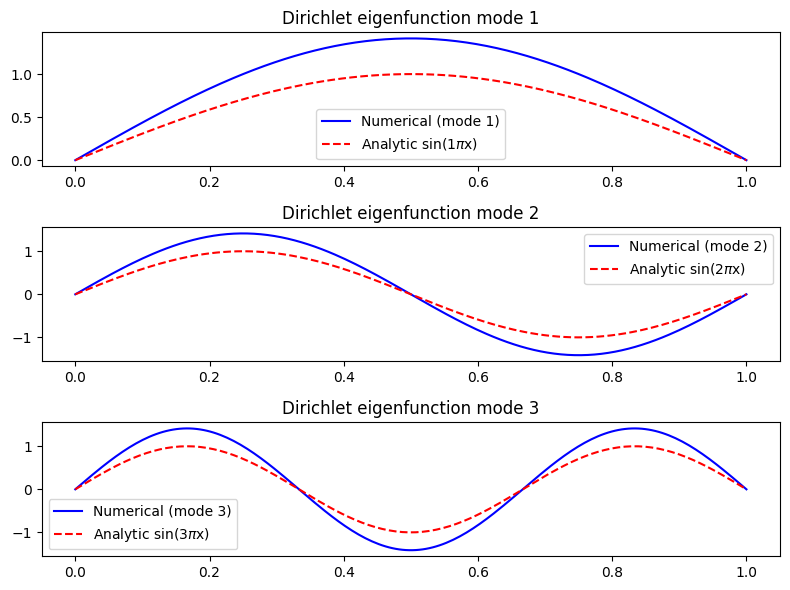

Inner product matrix (first three modes, should be nearly diagonal):
[[ 1.00000000e+00  1.42822660e-16 -1.51749077e-16]
 [ 1.42822660e-16  1.00000000e+00  7.85524632e-16]
 [-1.51749077e-16  7.85524632e-16  1.00000000e+00]]


In [11]:
def demo_dirichlet():
    # Parameters
    N = 200                # Number of grid points (including endpoints)
    x = np.linspace(0, 1, N)
    h = x[1] - x[0]
    # Impose u(0)=u(1)=0 so only interior points (i=1,...,N-2) are unknown.
    M = N - 2              # Number of unknowns
    # Build finite-difference matrix for -u'':
    #   - (u[i+1] - 2u[i] + u[i-1]) / h^2 = ? u[i].
    diag = (2.0/h**2) * np.ones(M)
    offdiag = (-1.0/h**2) * np.ones(M-1)
    A = np.diag(diag) + np.diag(offdiag, k=1) + np.diag(offdiag, k=-1)
    evals, evecs = eigh(A)
    
    # Normalize eigenfunctions
    for i in range(M):
        norm = np.sqrt(np.sum(evecs[:, i]**2) * h)
        evecs[:, i] /= norm
    
    # Add boundary values (u=0 at endpoints) for plotting.
    eigfuncs = []
    for i in range(evecs.shape[1]):
        u = np.zeros(N)
        u[1:-1] = evecs[:, i]
        eigfuncs.append(u)
    eigfuncs = np.array(eigfuncs)  # shape (n_modes, N)

    # Plot the first three eigenfunctions vs. analytic sin(npx)
    plt.figure(figsize=(8, 6))
    modes_to_plot = 3
    for n in range(modes_to_plot):
        plt.subplot(modes_to_plot, 1, n+1)
        plt.plot(x, eigfuncs[n, :], 'b-', label=f'Numerical (mode {n+1})')
        plt.plot(x, np.sin((n+1) * np.pi * x), 'r--', label=rf'Analytic sin({n+1}$\pi$x)')
        plt.title(f'Dirichlet eigenfunction mode {n+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Also print a small inner product matrix for the first three modes.
    inner = np.zeros((modes_to_plot, modes_to_plot))
    for i in range(modes_to_plot):
        for j in range(modes_to_plot):
            inner[i, j] = np.sum(eigfuncs[i, :] * eigfuncs[j, :]) * h
    print("Inner product matrix (first three modes, should be nearly diagonal):")
    print(inner)

# Run Demo 1
demo_dirichlet()

## Demo 2: Completeness Demonstration

In this section, we expand an arbitrary function $f(x)=x(1-x)$ in the eigenbasis obtained from the Dirichlet problem.

The expansion coefficients are computed via the inner product

$$
c_n = \langle f| u_n \rangle,
$$

and we reconstruct $f(x)$ using a finite number of modes. The original function, its reconstruction, and the reconstruction error are plotted.

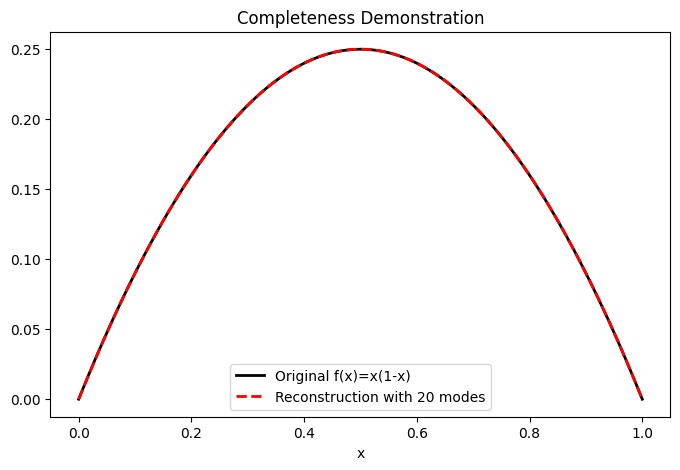

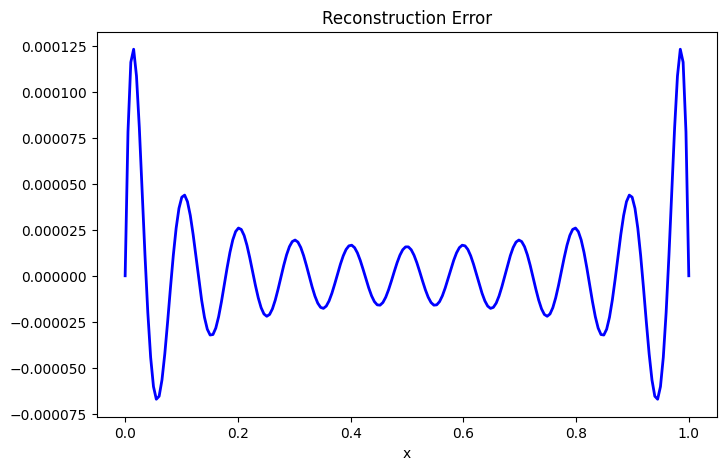

In [12]:
def demo_completeness():
    # Use the same eigenfunctions from Demo 1 (Dirichlet problem).
    N = 200
    x = np.linspace(0, 1, N)
    h = x[1] - x[0]
    M = N - 2
    diag = (2.0/h**2) * np.ones(M)
    offdiag = (-1.0/h**2) * np.ones(M-1)
    A = np.diag(diag) + np.diag(offdiag, k=1) + np.diag(offdiag, k=-1)
    evals, evecs = eigh(A)
    for i in range(M):
        norm = np.sqrt(np.sum(evecs[:, i]**2) * h)
        evecs[:, i] /= norm
    # Add boundary zeros:
    eigfuncs = []
    for i in range(evecs.shape[1]):
        u = np.zeros(N)
        u[1:-1] = evecs[:, i]
        eigfuncs.append(u)
    eigfuncs = np.array(eigfuncs)  # shape (n_modes, N)

    # Define an arbitrary function f(x) to expand:
    f = x * (1 - x)
    
    # Compute expansion coefficients c_n
    n_modes = 20  # Number of modes to include in the expansion
    coeffs = []
    for n in range(n_modes):
        c = np.sum(f * eigfuncs[n, :]) * h
        coeffs.append(c)
    coeffs = np.array(coeffs)
    # Reconstruct f(x)
    f_approx = np.zeros_like(f)
    for n in range(n_modes):
        f_approx += coeffs[n] * eigfuncs[n, :]
        
    # Plot the original f and its reconstruction:
    plt.figure(figsize=(8, 5))
    plt.plot(x, f, 'k-', lw=2, label='Original f(x)=x(1-x)')
    plt.plot(x, f_approx, 'r--', lw=2, label=f'Reconstruction with {n_modes} modes')
    plt.xlabel('x')
    plt.legend()
    plt.title('Completeness Demonstration')
    plt.show()
    
    # Plot the reconstruction error:
    plt.figure(figsize=(8, 5))
    plt.plot(x, f - f_approx, 'b-', lw=2)
    plt.xlabel('x')
    plt.title('Reconstruction Error')
    plt.show()

# Run Demo 2
demo_completeness()

## Demo 3: Orthogonality Visualization

In this demonstration, we visualize the orthogonality of the eigenfunctions computed from the Dirichlet problem.

We compute the inner product matrix $\langle u_i| u_j \rangle$ for the first few modes and display it as a heatmap. In addition, we plot the absolute deviation $|\langle u_i|u_j \rangle - \delta_{ij}|$ to show how close the eigenfunctions are to being perfectly orthogonal.

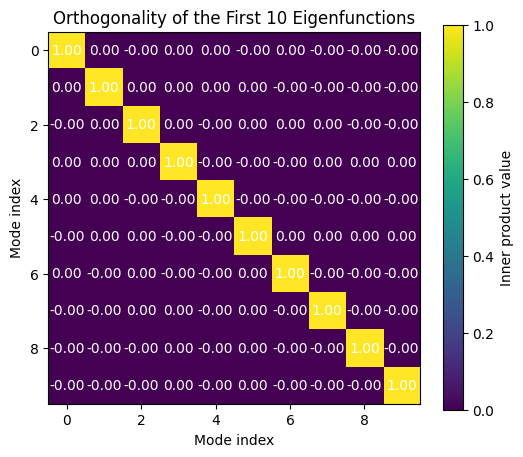

In [7]:
def demo_orthogonality():
    # Recompute the eigenfunctions from the Dirichlet problem.
    N = 200
    x = np.linspace(0, 1, N)
    h = x[1] - x[0]
    M = N - 2
    diag = (2.0/h**2) * np.ones(M)
    offdiag = (-1.0/h**2) * np.ones(M-1)
    A = np.diag(diag) + np.diag(offdiag, k=1) + np.diag(offdiag, k=-1)
    evals, evecs = eigh(A)
    for i in range(M):
        norm = np.sqrt(np.sum(evecs[:, i]**2) * h)
        evecs[:, i] /= norm
    # Add boundary zeros for plotting purposes.
    eigfuncs = []
    for i in range(evecs.shape[1]):
        u = np.zeros(N)
        u[1:-1] = evecs[:, i]
        eigfuncs.append(u)
    eigfuncs = np.array(eigfuncs)  # shape (n_modes, N)
    
    # Select a number of modes for which to visualize orthogonality.
    n_modes = 10
    inner = np.zeros((n_modes, n_modes))
    for i in range(n_modes):
        for j in range(n_modes):
            inner[i, j] = np.sum(eigfuncs[i, :] * eigfuncs[j, :]) * h

    # Visualize the inner product matrix as a heatmap.
    plt.figure(figsize=(6, 5))
    im = plt.imshow(inner, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, label='Inner product value')
    plt.title(f'Orthogonality of the First {n_modes} Eigenfunctions')
    plt.xlabel('Mode index')
    plt.ylabel('Mode index')
    # Annotate the heatmap with numerical values.
    for i in range(n_modes):
        for j in range(n_modes):
            plt.text(j, i, f"{inner[i, j]:.2f}", ha="center", va="center", color="w")
    plt.show()
    

# Run Demo 3
demo_orthogonality()